In [1]:
# load Google Driver
from google.colab import drive
import sys, os
drive.mount('/content/drive')

my_path = '/content/drive/My Drive/Computer Vision/Extensive VisionAI (EVA5)/06_Regularization & Modular Coding'
sys.path.append(my_path)
os.listdir(my_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['01_MNIST - Baseline.ipynb',
 '03_Modular_trial.ipynb',
 '03_Modular_FINAL.ipynb',
 '04_Modular+regularization_FINAL.ipynb',
 '02_visualize_misclassified.ipynb',
 '05_Modular+GBN_FINAL.ipynb',
 'outputs',
 'VS_NET.py',
 '__pycache__',
 'Test_Train.py',
 'Plots.py',
 '06_Modular_Main.ipynb',
 '07_Modular+GBN_FINAL.ipynb',
 'GBN_NET.py']

In [2]:
# import

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.functional as F
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

# import for all the modular codes
import VS_NET
import Test_Train
import Plots
import GBN_NET



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Modelling options for the loop


d1 = {'NO L1&L1': [0.,0.,'model'],
      'L1 Only': [1e-04,0.,'model'], 
      'L2 Only': [0.,1e-04,'model'],
      'L1&L2':[1e-04,1e-04,'model'],
      'GBN Only': [0,0,'model2'],
      'GBN with L1 and L2':[1e-04,1e-04,'model2']}

#initializers 
dropout_value = 0.05
num_splits=2
EPOCHS = 25

metric_values = {}
models={}

batch_size_GPU=128
batch_size_CPU=64




In [4]:
# Transforms

train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,),(0.3081,))
                                       ])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),(0.3081,))
                                      ])


In [5]:
# download data
train = datasets.MNIST('./data',train=True,transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform =test_transforms, download=True)

In [6]:
# Data loader
SEED=1
cuda = torch.cuda.is_available()

# torch.manual_seed(SEED)

# if cuda:
#   torch.cuda.manual_seed(SEED)

torch.cuda.manual_seed(SEED) if cuda else torch.manual_seed(SEED)

dataloader_args=dict(shuffle=True,batch_size=batch_size_GPU, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=batch_size_CPU)

# Train loader
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


torch.Size([128, 1, 28, 28]) torch.Size([1, 28, 28])
(28, 28)


Text(0.5, 1.0, '8')

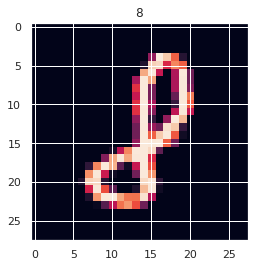

In [7]:
# Visualize Data

dataiter = iter(train_loader)
images,labels = dataiter.next()

print(images.shape, images[0].shape)

print(images[0].numpy().squeeze().shape) # squeeze removes the channel value. 
%matplotlib inline
plt.imshow(images[0].numpy().squeeze())
plt.title(labels[0].item()) #item converts from tensor to value

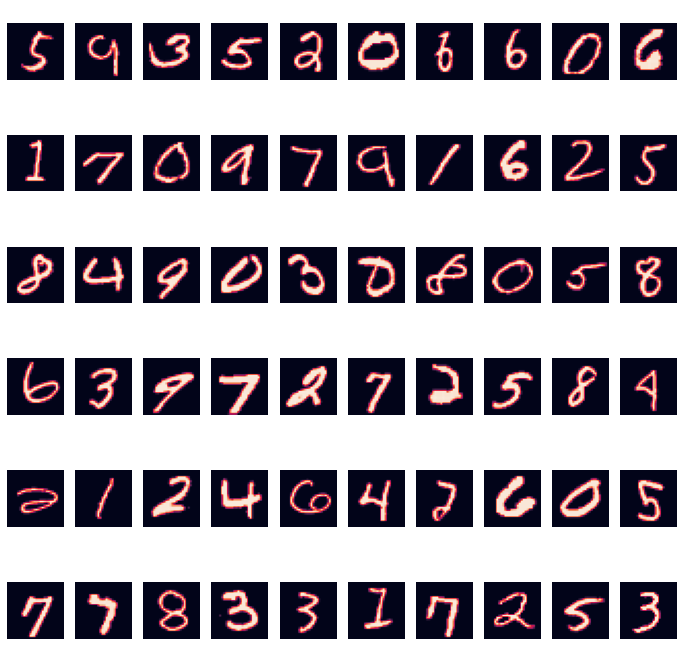

In [8]:
# visualize data in grid format

figure = plt.figure(figsize=(12,12))
num_of_images = 60

for index in range(1, num_of_images+1):
  plt.subplot(6,10,index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze())
  plt.title(labels[index].item(),color='w')

# Network with and without GBN

In [9]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = VS_NET.Net(dropout_value).to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 10,

#GBN Architecture

In [10]:
# # num_splits=2

# class BatchNorm(nn.BatchNorm2d):
#     def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
#         super().__init__(num_features, eps=eps, momentum=momentum)
#         self.weight.data.fill_(1.0)
#         self.bias.data.fill_(0.0)
#         self.weight.requires_grad = weight
#         self.bias.requires_grad = bias

# class GhostBatchNorm(BatchNorm):
#     def __init__(self, num_features, num_splits, **kw):
#         super().__init__(num_features, **kw)
#         self.num_splits = num_splits
#         self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
#         self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

#     def train(self, mode=True):
#         if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
#             self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
#                 self.num_splits)
#             self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
#                 self.num_splits)
#         return super().train(mode)

#     def forward(self, input):
#         N, C, H, W = input.shape
#         if self.training or not self.track_running_stats:
#             return F.batch_norm(
#                 input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
#                 self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
#                 True, self.momentum, self.eps).view(N, C, H, W)
#         else:
#             return F.batch_norm(
#                 input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
#                 self.weight, self.bias, False, self.momentum, self.eps)


In [11]:
# # GBN Architecture


# class Net_GBN(nn.Module):
#     def __init__(self):
#         super(Net_GBN, self).__init__()
#         # Input Block
#         self.convblock1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             GhostBatchNorm(num_features=10,num_splits=num_splits),
#             nn.Dropout(dropout_value)
#         ) # output_size = 26

#         # CONVOLUTION BLOCK 1
#         self.convblock2 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             GhostBatchNorm(num_features=10,num_splits=num_splits),
#             nn.Dropout(dropout_value)
#         ) # output_size = 24
#         self.convblock3 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             GhostBatchNorm(num_features=16,num_splits=num_splits),
#             nn.Dropout(dropout_value)
#         ) # output_size = 22
        

#         # TRANSITION BLOCK 1
#         self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
#         self.convblock4 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#             # nn.BatchNorm2d(10),
#             # nn.ReLU()
#         ) # output_size = 11

#         # CONVOLUTION BLOCK 2
#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             GhostBatchNorm(num_features=10,num_splits=num_splits),
#             nn.Dropout(dropout_value)
#         ) # output_size = 9
#         self.convblock6 = nn.Sequential(
#             nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             GhostBatchNorm(num_features=16,num_splits=num_splits),
#            nn.Dropout(dropout_value)
#         ) # output_size = 7
#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
#             nn.ReLU(),
#             GhostBatchNorm(num_features=16,num_splits=num_splits),
#             nn.Dropout(dropout_value)
#         ) # output_size = 5

#         self.convblock9 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
#             nn.ReLU(),
#             GhostBatchNorm(num_features=16,num_splits=num_splits),
#             nn.Dropout(dropout_value) 
#         ) # output_size = 3

#         self.gap = nn.Sequential(
#             nn.AvgPool2d(kernel_size=3)
#         )


#         # TRANSITION BLOCK 2
#         #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
#         self.convblock10 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
#             # nn.BatchNorm2d(10),
#             # nn.ReLU()
#         ) # output_size = 5

    

#     def forward(self, x):
#         x = self.convblock1(x)
#         x = self.convblock2(x)
#         x = self.convblock3(x)
#         x = self.pool1(x)
#         x = self.convblock4(x)
#         x = self.convblock5(x)
#         x = self.convblock6(x)
#         #x = self.convblock7(x)
#         x = self.convblock8(x)
#         x = self.convblock9(x)

#         x = self.gap(x)
#         x = self.convblock10(x)

#         #x = self.convblock11(x)
#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)


# from torchsummary import summary
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")
# model = Net_GBN().to(device)
# summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
    GhostBatchNorm-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
              ReLU-6           [-1, 10, 24, 24]               0
    GhostBatchNorm-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
             ReLU-10           [-1, 16, 22, 22]               0
   GhostBatchNorm-11           [-1, 16, 22, 22]              32
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14           [-1, 10,

In [11]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = GBN_NET.Net_GBN(dropout_value,num_splits).to(device)
# summary(model, input_size=(1, 28, 28))

# MODULAR

# RUN ALL MODELS IN LOOP

In [12]:


# print(d1)
for x in d1.keys():
  exp_name = x
  print('\nThis model is for :',exp_name)
  l1 = d1[x][0]
  l2 = d1[x][1]
  model_name = d1[x][2]
  # modelo = d1[x][3]

  if model_name == 'model':
      
    print('\n model name:',model_name)
    model =  VS_NET.Net(dropout_value).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.05)
    trainer = Test_Train.Trainer(model,device,train_loader,test_loader,optimizer,EPOCHS,scheduler)
    train_metric, test_metric = trainer.train(l1_lambda=l1, l2_lambda=l2)

  elif model_name == 'model2':
    print('\n model name:',model_name)
    # model2 =  Net_GBN().to(device)
    model2 = GBN_NET.Net_GBN(dropout_value,num_splits).to(device)
    optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=6, gamma=0.05)
    trainer = Test_Train.Trainer(model2,device,train_loader,test_loader,optimizer,EPOCHS,scheduler)
    train_metric, test_metric = trainer.train(l1_lambda=l1, l2_lambda=l2)


  # save the metrics in dictionary

  metric_values[exp_name] = (train_metric, test_metric)

  # print(x,d1[x][0],d1[x][1],d1[x][2])

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:351: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]


This model is for : NO L1&L1

 model name: model
EPOCH: 0
learning rate  [0.01]


Loss=0.14963039755821228 Batch_id=468 Accuracy=88.53: 100%|██████████| 469/469 [00:13<00:00, 34.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0782, Accuracy: 9783/10000 (97.83%)

EPOCH: 1
learning rate  [0.01]


Loss=0.08033553510904312 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:13<00:00, 33.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9875/10000 (98.75%)

EPOCH: 2
learning rate  [0.01]


Loss=0.05166422203183174 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9866/10000 (98.66%)

EPOCH: 3
learning rate  [0.01]


Loss=0.041634589433670044 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 34.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9895/10000 (98.95%)

EPOCH: 4
learning rate  [0.01]


Loss=0.058827076107263565 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:13<00:00, 33.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9909/10000 (99.09%)

EPOCH: 5
learning rate  [0.01]


Loss=0.029062634333968163 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9912/10000 (99.12%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.01627294532954693 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 33.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.014861561357975006 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.010433544404804707 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.28%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.004369875881820917 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.005144961178302765 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.004233787301927805 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.011171202175319195 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9927/10000 (99.27%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.014872937463223934 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 31.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9922/10000 (99.22%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.00867234542965889 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 31.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.007332178298383951 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.024368328973650932 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9929/10000 (99.29%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.021328158676624298 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.010298262350261211 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.026272648945450783 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)

EPOCH: 20
learning rate  [1.25e-06]


Loss=0.02607589401304722 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)

EPOCH: 21
learning rate  [1.25e-06]


Loss=0.008044344373047352 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9929/10000 (99.29%)

EPOCH: 22
learning rate  [1.25e-06]


Loss=0.07327086478471756 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)

EPOCH: 23
learning rate  [1.25e-06]


Loss=0.007363409269601107 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH: 24
learning rate  [3.1250000000000007e-09]


Loss=0.04920428991317749 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)


This model is for : L1 Only

 model name: model
EPOCH: 0
learning rate  [0.01]


Loss=0.14083169400691986 Batch_id=468 Accuracy=86.49: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0741, Accuracy: 9806/10000 (98.06%)

EPOCH: 1
learning rate  [0.01]


Loss=0.11465593427419662 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9854/10000 (98.54%)

EPOCH: 2
learning rate  [0.01]


Loss=0.12259098887443542 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0350, Accuracy: 9891/10000 (98.91%)

EPOCH: 3
learning rate  [0.01]


Loss=0.10373873263597488 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9908/10000 (99.08%)

EPOCH: 4
learning rate  [0.01]


Loss=0.07196081429719925 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:14<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9897/10000 (98.97%)

EPOCH: 5
learning rate  [0.01]


Loss=0.07493384927511215 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9893/10000 (98.93%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.06354880332946777 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9925/10000 (99.25%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.0662907063961029 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9922/10000 (99.22%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.05992351472377777 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.06908778101205826 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.07453662157058716 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.08056990057229996 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9927/10000 (99.27%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.06141987815499306 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9934/10000 (99.34%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.06419539451599121 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 33.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.07705596834421158 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9930/10000 (99.30%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.07278333604335785 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.07599583268165588 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.05880264192819595 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9928/10000 (99.28%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.06483221799135208 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.0712929219007492 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 33.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9929/10000 (99.29%)

EPOCH: 20
learning rate  [1.25e-06]


Loss=0.0719555914402008 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

EPOCH: 21
learning rate  [1.25e-06]


Loss=0.0712561309337616 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

EPOCH: 22
learning rate  [1.25e-06]


Loss=0.06611785292625427 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9938/10000 (99.38%)

EPOCH: 23
learning rate  [1.25e-06]


Loss=0.0701863244175911 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9930/10000 (99.30%)

EPOCH: 24
learning rate  [3.1250000000000007e-09]


Loss=0.07025157660245895 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)


This model is for : L2 Only

 model name: model
EPOCH: 0
learning rate  [0.01]


Loss=0.2695940136909485 Batch_id=468 Accuracy=89.34: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1036, Accuracy: 9719/10000 (97.19%)

EPOCH: 1
learning rate  [0.01]


Loss=0.07711531966924667 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9860/10000 (98.60%)

EPOCH: 2
learning rate  [0.01]


Loss=0.1298600435256958 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9844/10000 (98.44%)

EPOCH: 3
learning rate  [0.01]


Loss=0.09409992396831512 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:14<00:00, 32.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9885/10000 (98.85%)

EPOCH: 4
learning rate  [0.01]


Loss=0.0440608486533165 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:14<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9912/10000 (99.12%)

EPOCH: 5
learning rate  [0.01]


Loss=0.044487666338682175 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:15<00:00, 30.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9928/10000 (99.28%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.040684279054403305 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:15<00:00, 30.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.025483129546046257 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9943/10000 (99.43%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.06983659416437149 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9942/10000 (99.42%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.03592053800821304 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9940/10000 (99.40%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.037009790539741516 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9942/10000 (99.42%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.041721783578395844 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9944/10000 (99.44%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.06344978511333466 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.08798794448375702 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9939/10000 (99.39%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.034236520528793335 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9946/10000 (99.46%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.044456593692302704 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9944/10000 (99.44%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.048982709646224976 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9944/10000 (99.44%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.11704763025045395 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9945/10000 (99.45%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.051801227033138275 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9943/10000 (99.43%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.04794182628393173 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9943/10000 (99.43%)

EPOCH: 20
learning rate  [1.25e-06]


Loss=0.02753644995391369 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9946/10000 (99.46%)

EPOCH: 21
learning rate  [1.25e-06]


Loss=0.03595546633005142 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9945/10000 (99.45%)

EPOCH: 22
learning rate  [1.25e-06]


Loss=0.05324799567461014 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9945/10000 (99.45%)

EPOCH: 23
learning rate  [1.25e-06]


Loss=0.028390834107995033 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9944/10000 (99.44%)

EPOCH: 24
learning rate  [3.1250000000000007e-09]


Loss=0.06177952140569687 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9947/10000 (99.47%)


This model is for : L1&L2

 model name: model
EPOCH: 0
learning rate  [0.01]


Loss=0.1304492950439453 Batch_id=468 Accuracy=89.31: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0776, Accuracy: 9808/10000 (98.08%)

EPOCH: 1
learning rate  [0.01]


Loss=0.1574035882949829 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9876/10000 (98.76%)

EPOCH: 2
learning rate  [0.01]


Loss=0.14320017397403717 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:14<00:00, 32.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9881/10000 (98.81%)

EPOCH: 3
learning rate  [0.01]


Loss=0.09872261434793472 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0335, Accuracy: 9900/10000 (99.00%)

EPOCH: 4
learning rate  [0.01]


Loss=0.09549091011285782 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9911/10000 (99.11%)

EPOCH: 5
learning rate  [0.01]


Loss=0.121135413646698 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9890/10000 (98.90%)

EPOCH: 6
learning rate  [2.5e-05]


Loss=0.08761005848646164 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:14<00:00, 32.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9929/10000 (99.29%)

EPOCH: 7
learning rate  [0.0005]


Loss=0.08262194693088531 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 8
learning rate  [0.0005]


Loss=0.089263916015625 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9928/10000 (99.28%)

EPOCH: 9
learning rate  [0.0005]


Loss=0.08751809597015381 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 33.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9932/10000 (99.32%)

EPOCH: 10
learning rate  [0.0005]


Loss=0.0839141458272934 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 11
learning rate  [0.0005]


Loss=0.09509163349866867 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 31.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9935/10000 (99.35%)

EPOCH: 12
learning rate  [1.25e-06]


Loss=0.11783550679683685 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9928/10000 (99.28%)

EPOCH: 13
learning rate  [2.5e-05]


Loss=0.10323731601238251 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9927/10000 (99.27%)

EPOCH: 14
learning rate  [2.5e-05]


Loss=0.0809355303645134 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9936/10000 (99.36%)

EPOCH: 15
learning rate  [2.5e-05]


Loss=0.08218149840831757 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 16
learning rate  [2.5e-05]


Loss=0.07780198752880096 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9932/10000 (99.32%)

EPOCH: 17
learning rate  [2.5e-05]


Loss=0.0977669507265091 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)

EPOCH: 18
learning rate  [6.250000000000001e-08]


Loss=0.08309474587440491 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9932/10000 (99.32%)

EPOCH: 19
learning rate  [1.25e-06]


Loss=0.1050771176815033 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9930/10000 (99.30%)

EPOCH: 20
learning rate  [1.25e-06]


Loss=0.09931325912475586 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9927/10000 (99.27%)

EPOCH: 21
learning rate  [1.25e-06]


Loss=0.08353090286254883 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)

EPOCH: 22
learning rate  [1.25e-06]


Loss=0.08292342722415924 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9928/10000 (99.28%)

EPOCH: 23
learning rate  [1.25e-06]


Loss=0.07796598225831985 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)

EPOCH: 24
learning rate  [3.1250000000000007e-09]


Loss=0.12307265400886536 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9931/10000 (99.31%)


This model is for : GBN Only

 model name: model2
EPOCH: 0
learning rate  [0.01]


RuntimeError: ignored

In [ ]:
Plots.multi_plots_loss(metric_values)
Plots.multi_plots_acc(metric_values)

# Plot misclassified

In [ ]:
# plot_misclassified(model2,test_loader,device)

Plots.plot_misclassified(model2,test_loader,device)